In [1]:
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model

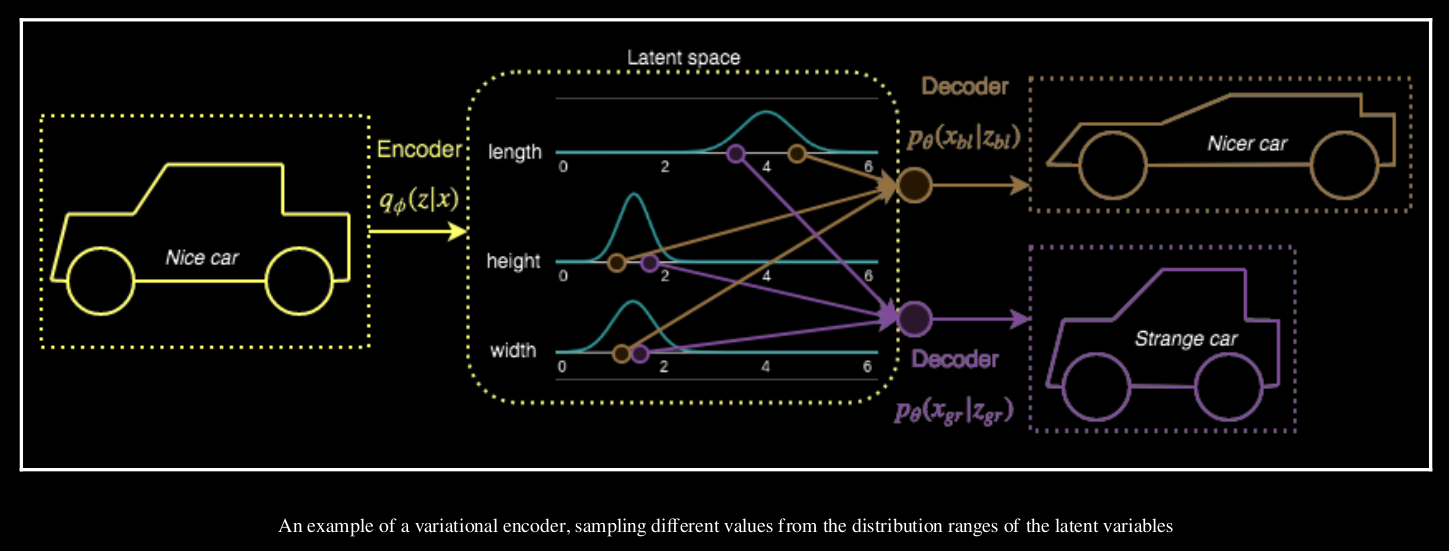

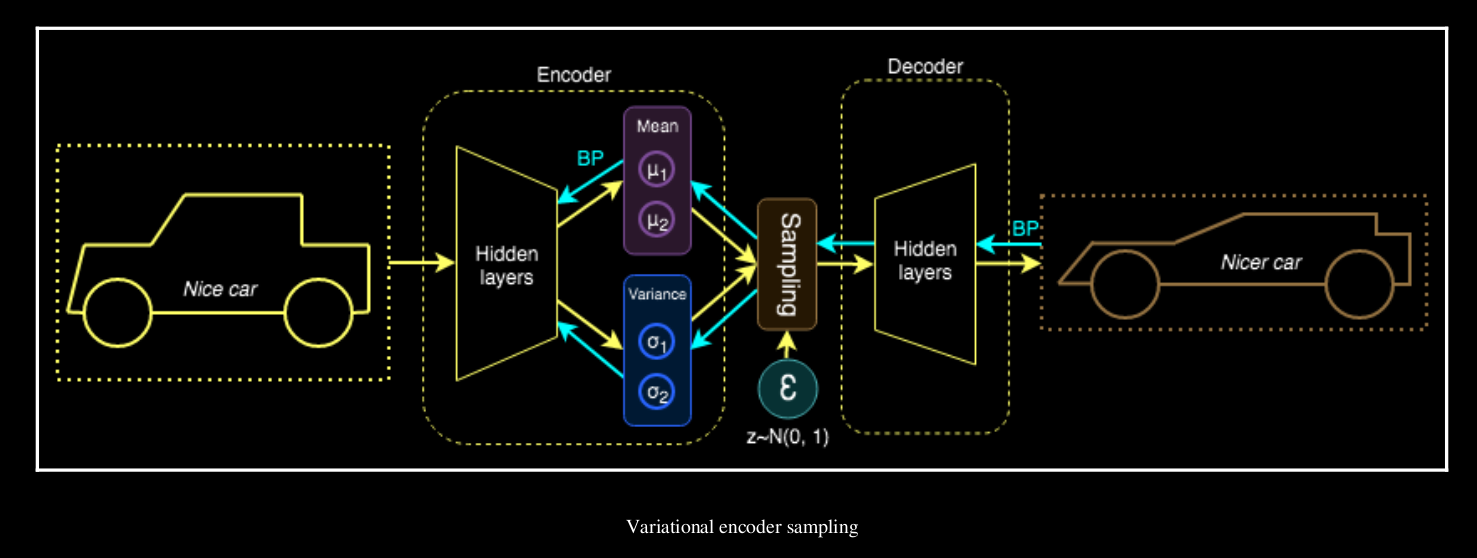

In [9]:
#1.We load the mnist dataset as always
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#2.Image size we now my experience that those images are 28x28 pixel and have 1 channel
image_size = x_train.shape[1]*x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size])
x_test = np.reshape(x_test, [-1, image_size])
#3.We normalize the images diving by 255 because that is the highedt the color range can go. Its completly white.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


In [15]:
#4.we are going to have an enconder, decoder and the nertowork in this function
#5.Intermediate_dim is the number of neurons in the hidden layer of the encoder/decoder
#6.The latent space dimension=2 because it only cares about the mean and the variance of the distribution he is going to be sampling from.
def build_vae(intermediate_dim=512, latent_dim=2):
#---------------------encoder------------------------------------    
#7.Input is a function from keras that produces an empty tensor the size of the image size
    inputs=Input(shape=(image_size,),name='encoder_input')
#8.X son las 512 hidden layers que terminan en relu activation function    
    x=Dense(intermediate_dim,activation='relu')(inputs)
#9.Ahora llego al a los parametros que me interesan en este caso la media y la varianza. Son 2 medias por que es height y width las unicas medidas de la imagen( no son 3 por qu falta la intensidad del pixel?)
    z_mean=Dense(latent_dim,name='z_mean')(x)
    z_log_var=Dense(latent_dim,name='z_log_var')(x)
#10.Truco the Reparametrizatin, aqui usa Lambda para llamar la funcion 'sampling' sobre los vectores z_mean, z_log va y devuelve un array de 2 dim [z_mean=1,z_log_var=2]
    z=Lambda(sampling,output_shape=(latent_dim,),name='z')([z_mean,z_log_var])
#-----------------Full-Encoder Model------------------------------
    encoder=Model(inputs,[z_mean,z_log_var,z],name='encoder')
    encoder.summary()
#---------------------Decoder-------------------------------------
#11.My latent inputs are the mean and variable of the distribution. 
    latent_inputs=Input(shape=(latent_dim,),name='z_sampling')
#12.Here I am addind a single hidden layer with 512 neurons, that takes the latent inputs with a relu activaion function.    
    x=Dense(intermediate_dim, activation='relu')(latent_inputs)
#13.I connect this layer with an output layer that has the image size.    
    outputs = Dense(image_size, activation='sigmoid')(x)
#14.I initialize the model of the decoder.
    decoder=Model(latent_inputs, outputs,name='decoder')
#------------------VAE Model-------------------------------------
#15.Defino los outputs del model vae.  
    outputs=decoder(encoder(inputs)[2])
    vae=Model(inputs,outputs,name='vae')
#-----------------Loss Function----------------------------------
#16.Just like in any model we dine the loss function.
    reconstruction_loss=binary_crossentropy(inputs, outputs)*image_size
    kl_loss =1+z_log_var-K.square(z_mean)-K.exp(z_log_var)
    kl_loss =K.sum(kl_loss, axis=-1)
    kl_loss*=-0.5
#17.We combine them in a total loss.
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    return encoder, decoder, vae

In [16]:
#Define the sampling function
def sampling(args: tuple):
    # unpack the input tuple
    z_mean, z_log_var = args
    # mini-batch size
    mb_size = K.shape(z_mean)[0]
    # latent space size
    dim = K.int_shape(z_mean)[1]
    # random normal vector with mean=0 and std=1.0
    epsilon = K.random_normal(shape=(mb_size, dim))
    # Esta es la distribution Empirica de la data
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [18]:
# Plot the distributions of the mean and the variance:
def plot_latent_distribution(encoder,x_test,y_test,batch_size=128):
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    markers = ('o', 'x', '^', '<', '>', '*', 'h', 'H', 'D', 'd','P', 'X', '8', 's', 'p')
    for i in np.unique(y_test):
        plt.scatter(z_mean[y_test == i, 0], z_mean[y_test == i, 1],marker=MarkerStyle(markers[i],fillstyle='none'),edgecolors='black')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


In [19]:
def plot_generated_images(decoder):
    # display a nxn 2D manifold of digits
    n = 15
    digit_size = 28
    figure = np.zeros((digit_size*n, digit_size*n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    # start sampling z1 and z2 in the ranges grid_x and grid_y
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = digit
    # plot the results
    plt.figure(figsize=(6, 5))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
____________________________________________________________________________________________

469/469 [==============================] - 4s 9ms/step - loss: 155.2629 - val_loss: 156.2784
Epoch 17/50
469/469 [==============================] - 4s 9ms/step - loss: 154.6405 - val_loss: 155.9579
Epoch 18/50
469/469 [==============================] - 4s 9ms/step - loss: 154.1968 - val_loss: 155.6207
Epoch 19/50
469/469 [==============================] - 4s 8ms/step - loss: 153.9263 - val_loss: 155.5882
Epoch 20/50
469/469 [==============================] - 4s 8ms/step - loss: 154.0410 - val_loss: 154.9980
Epoch 21/50
469/469 [==============================] - 4s 8ms/step - loss: 153.4607 - val_loss: 154.7600
Epoch 22/50
469/469 [==============================] - 4s 10ms/step - loss: 152.8496 - val_loss: 155.0634
Epoch 23/50
469/469 [==============================] - 4s 9ms/step - loss: 152.7258 - val_loss: 154.5182
Epoch 24/50
469/469 [==============================] - 5s 11ms/step - loss: 152.4697 - val_loss: 154.1678
Epoch 25/50
469/469 [==============================] - 4s 9ms/ste

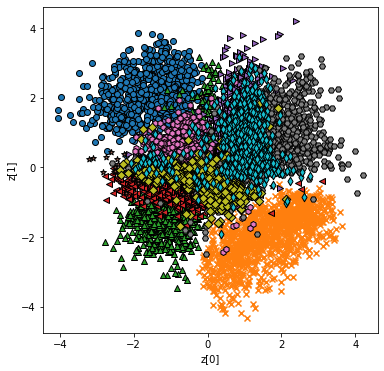

ValueError: The number of FixedLocator locations (16), usually from a call to set_ticks, does not match the number of ticklabels (15).

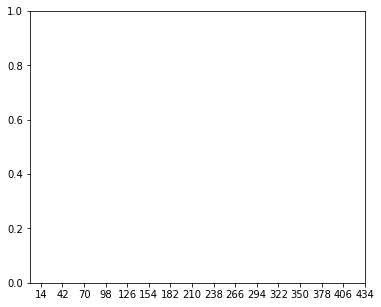

In [20]:
encoder, decoder, vae = build_vae()
vae.compile(optimizer='adam')
vae.summary()
vae.fit(x_train,
epochs=50,
batch_size=128,
validation_data=(x_test, None))
plot_latent_distribution(encoder,
x_test,
y_test,
batch_size=128)
plot_generated_images(decoder)